## Simulating LSST-like image time-series of lensed type Ia supernovae

### Import python libraries, LSST characteristics and functions

In [5]:
from class_LSST import LSST
from image_time_series import simulate_time_series_images
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Parameter distributions 

Sample $z_l$, $z_s$ and $\theta_E$ from MC sample from Wojtak et al. (2019).


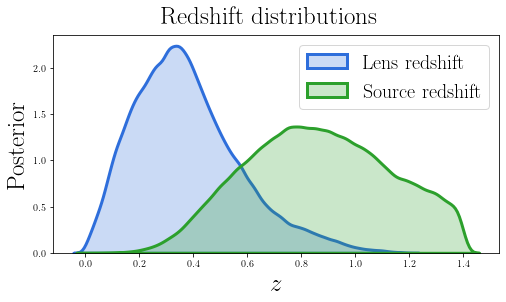

In [2]:
lsst = LSST(bandpass='i')

z_source_list_, z_lens_list_, theta_E_list_ = lsst.get_z_theta(theta_min=0.1)

lsst.plot_redshifts(z_lens_list_, z_source_list_)

### Cadence

Sample the inter-night gaps from the predicted distribution for the <b> baseline2018a </b> observing strategy for the LSST Wide, Fast, Deep survey in the $i$-band.


Median inter-night gap:  6.9835000000020955


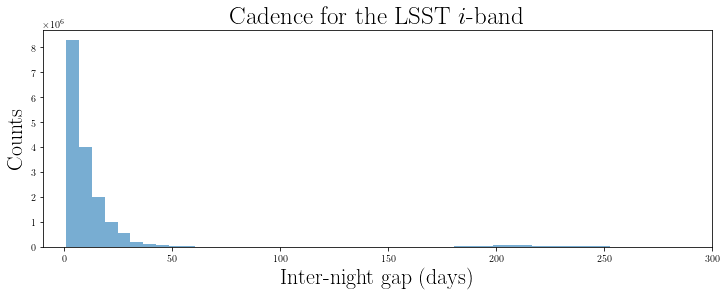

In [3]:
inter_night_gap = lsst.get_inter_night_gap()
print("Median inter-night gap: ", np.median(inter_night_gap))

lsst.plot_inter_night_gap(inter_night_gap)

### Generation of training and test sets


  0%|          | 0/1 [00:00<?, ?it/s]

 
Peak brightness images: [21.99218865 23.71780864]
Time delays:  [ 0.         35.75026534] days
Macro magnification:  [4.57771273 5.17536882]
Microlensing contribution at peak (magnitudes):  [-0.61  1.22]
Lens redshift:  0.39336624634963546
Supernova redshift:  0.7546513985122496
Einstein radius:  1.0784930366471122
Hubble constant:  70.0
Time-delay distance:  3589.7543385140466
 


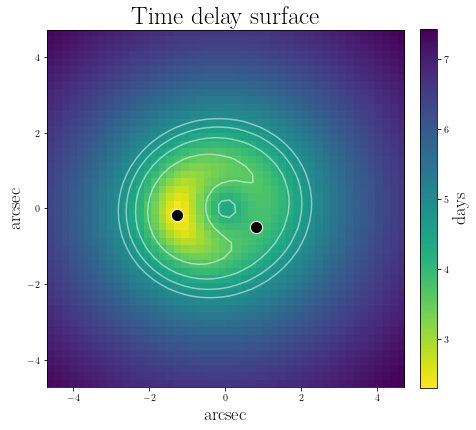

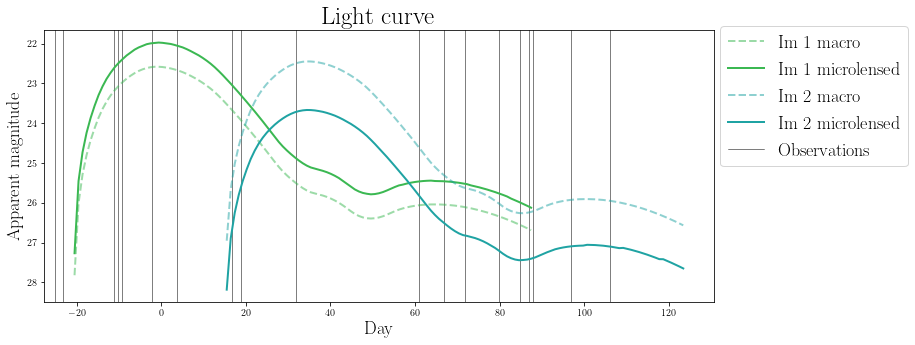

100%|██████████| 1/1 [00:58<00:00, 58.67s/it]


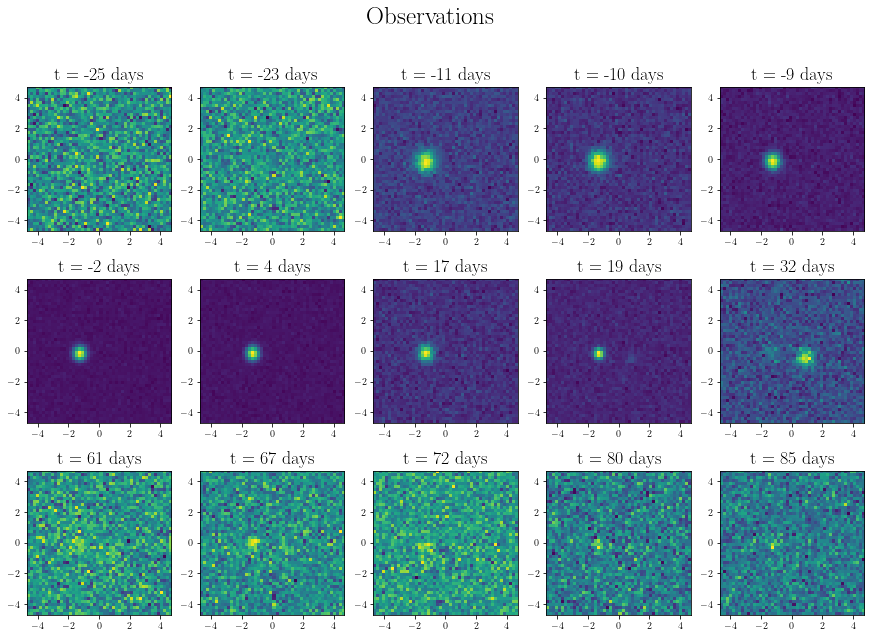

100%|██████████| 1/1 [00:10<00:00, 10.45s/it]

Done!
Simulating images took  10.0 seconds ( 0.0 hours) to complete.
Number of image-time series generated:  1
Number of configurations tried:  3
Number of attempts:  541
 
                                         time_series  z_source    z_lens  \
0  [[[0.7180036869501705, 11.889160618766272, -0....  0.754651  0.393366   

     H0   theta_E                       peak_brightness_im  \
0  70.0  1.078493  [21.992188654660488, 23.71780863835892]   

                                macro_mag  source_x  source_y  \
0  [4.577712729150057, 5.175368816876869]  -0.14693  0.012901   

                 time_delay  ...   e1_lens   e2_lens  \
0  [0.0, 35.75026534090723]  ... -0.007208 -0.064038   

                                         time_stamps  g1_shear  g2_shear  \
0  [0.0, 1.9587000000028638, 13.912800000005518, ...   0.04351  0.005677   

                                micro_kappa  \
0  [0.4068136039070959, 0.6033162858357579]   

                               micro_gamma  \
0  [0.36526

In [10]:
num_samples = 1               # Total number of lens systems to be generated  
batch_size = 1                # Number of lens systems that is saved together in a batch
batch = 7                     # Starting number of the batch
num_images = 2                # Choose between 2 (for doubles) and 4 (for quads)
bandpass = 'i'                # Choose between 'r', 'i' or 'z'
obs_upper_limit = 20          # Upper limit of number of observations
obs_lower_limit = 5           # Lower limit of number of observations
fixed_H0 = True               # Bool, if False: vary H0. if True: fix H0 to 70 km/s/Mpc (for the evaluation set)
add_microlensing = True      # Bool, if False: Only macro magnification. if True: Add effects of microlensing
Show = True                   # Bool, if True: Show figures and print information about the lens systems
Save = False                  # Bool, if True: Save image time-series
path = "../processed_data/Cadence_microlensing_evaluationset_doubles2/" # Path to folder in which to save the results


simulate_time_series_images(batch_size, batch,  num_samples, num_images, inter_night_gap, z_source_list_, z_lens_list_, 
                            theta_E_list_, lsst, bandpass, add_microlensing, obs_lower_limit, obs_upper_limit, 
                            fixed_H0, Show, Save, path)
